In [1]:
!pip install z3-solver

     |████████████████████████████████| 33.0 MB 17 kB/s 


In [2]:
!pip install tabulate

In [3]:
from z3 import *
import itertools

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time, math, random
from tabulate import tabulate

In [4]:
#skip if not in drive
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/MyDrive/SAT

Mounted at /gdrive
/gdrive/MyDrive/SAT


#Auxiliary functions

In [5]:
def plot_result(rects, W,H):
    w = W

    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.add_subplot(111, aspect='equal')
    for i in range(len(rects)):
        ax1.add_patch(patches.Rectangle((rects[i][2], rects[i][3]), rects[i][0], rects[i][1], edgecolor='black', facecolor=random.choice(['r', 'g', 'y','b'])))

    plt.xticks(range(W+1))
    plt.yticks(range(max([rects[i][3]+rects[i][1] for i in range(len(rects))])+1))
    #plt.grid(b=True, which='major', color='#666666', linestyle='-')
    plt.show()

In [6]:
def return_coods(m,l,px,py):
  x_r =[]
  y_r=[]
  for r in range(l):
    x_r.append([m.eval(x) for x in px[r]].index(True))

  for r in range(len(rects)):
    y_r.append([m.eval(x) for x in py[r]].index(True))

  return list(zip(x_r,y_r))

#Direct Encoding

In [7]:
def at_least_one(bool_vars):
    return Or(bool_vars)

def at_most_one(bool_vars):
    return [Not(And(pair[0], pair[1])) for pair in itertools.combinations(bool_vars, 2)]

In [8]:
def base_model_direct(s,rects,px,py,under,left,W,H):
  #exclude impossible values
  for r in range(len(rects)):
    for i in range(W-rects[r][0]+1,W):
      s.add(Not(px[r][i]))
    for j in range(H-rects[r][1]+1,H):
      s.add(Not(py[r][j]))

  #each r has one and only one (xi,yi)
  for r in range(len(rects)):
    s.add(at_least_one(px[r]))
    s.add(at_least_one(py[r]))
    s.add(at_most_one(px[r]))
    s.add(at_most_one(py[r]))

  #non overlapping
  for (i,j) in itertools.combinations(range(len(rects)),2):
    s.add(Or(left[i][j],left[j][i],under[i][j],under[j][i]))

  #rectangles with wi+wj > W (same with H) can't be in the same line
  for (ri,rj) in itertools.combinations(range(len(rects)),2):
    if (rects[ri][0] + rects[rj][0] > W):
      s.add(Not(left[ri][rj]))
      s.add(Not(left[rj][ri]))
    if (rects[ri][1] + rects[rj][1] > H):
      s.add(Not(under[ri][rj]))
      s.add(Not(under[rj][ri]))

  #meaning for left and under
  for ri in range(len(rects)):
    for rj in range(len(rects)):
      if ri != rj:
        for x in range(0,rects[ri][0]):
          s.add(Or(
              Not(left[ri][rj]),
              Not(px[rj][x])
          )) # left(ri,rj) -> xj > wi
        for x in range(W-rects[ri][0]-rects[rj][0]+1,W):
          s.add(Or(
              Not(left[ri][rj]),
              Not(px[ri][x])
          )) #left(ri,rj) -> xi < W-wi-wj
        for xi in range(0,W-rects[ri][0]-rects[rj][0]+1):
          for xj in range(0, xi+rects[ri][0]):
            s.add(Or(
                Not(left[ri][rj]),
                Or(Not(px[ri][xi]),
                        Not(px[rj][xj])
                )
            )) #left(ri,rj) -> xi+wi<xj
        
        
        for y in range(0,rects[ri][1]):
          s.add(Or(
              Not(under[ri][rj]),
              Not(py[rj][y])
          )) #under(ri,rj) -> yj >yi
        for y in range(H-rects[ri][1]-rects[rj][1]+1,H):
          s.add(Or(
              Not(under[ri][rj]),
              Not(py[ri][y])
          )) #under(ri,rj) -> yi < H-hi-hj
        for yi in range(0,H-rects[ri][1]-rects[rj][1]+1):
          for yj in range(0, yi+rects[ri][1]):
            s.add(Or(
                Not(under[ri][rj]),
                Or(
                    Not(py[ri][yi]),
                    Not(py[rj][yj]
                ))
            )) #under(ri,rj) -> yi+hi<yj
  return s

#Order Encoding


The "solve" method creates a different model for each attempted H, starting from the minimum, pre-defining H has the advantage of limiting the number of variables, but in case of failure it will need to re-learn clauses from zero for each new H.

##Base model

The base model includes the axioms for the type of encoding and the "definitions" for left and under. In addition, it includes the non overlapping conditions, i.e. each pair of rectangles must be in some kind of left/under relation.

In [9]:
def base_model_order(s,rects,px,py,under,left,W,H):
  #non overlapping condition
  for (i,j) in itertools.combinations(range(len(rects)),2):
    s.add(Or(left[i][j],left[j][i],under[i][j],under[j][i]))
  
  #implicit domains
  for r in range(len(rects)):
    for xi in range(W-rects[r][0],W):
      s.add(px[r][xi])
    for yi in range(H-rects[r][1],H):
      s.add(py[r][yi])
  #order encoding
  for r in range(len(rects)):
    for e in range(W-1):
      s.add(Or(Not(px[r][e]),px[r][e+1]))
    for f in range(H-1):
      s.add(Or(Not(py[r][f]),py[r][f+1]))

  

  #meaning for left and under
  for ri in range(len(rects)):
    for rj in range(len(rects)):
      if ri != rj :
        #print((ri,rj))
        s.add(Or(
            Not(left[ri][rj]),
            Not(px[rj][rects[ri][0]-1])
        )) # left(ri,rj) -> xj > wi, lower bound for xj
        for e in range(0,W-rects[ri][0]):
          s.add(Or(
              Not(left[ri][rj]),
              px[ri][e],
              Not(px[rj][e+rects[ri][0]])
          )) #for any e: left(ri,rj) -> (xi <e v ! xj<e+wi)

        s.add(Or(
            Not(under[ri][rj]),
            Not(py[rj][rects[ri][1]-1])
        )) #under(ri,rj)-> yj > hi, lower bound for yj

        for f in range(0,H-rects[ri][1]):
          s.add(Or(
              Not(under[ri][rj]),
              py[ri][f],
              Not(py[rj][f+rects[ri][1]])
        )) #for any f, under(ri,rj) -> (yj <= f+hi ->yi <= f)
  return s

## Optimization
The optimization steps mostly include symmetry breaking and implicit constraints in an attempt to riduce the search domain

In [10]:
def optimize(s,rects,px,py,under,left,W,H):
  #implict constraint: a rectangle can't be both right and left wrt another
  #same holds for under and over

  for (ri,rj) in itertools.combinations(range(len(rects)),2):
    s.add(Or(
        Not(left[ri][rj]),
        Not(left[rj][ri])
    ))
    s.add(Or(
        Not(under[ri][rj]),
        Not(under[rj][ri])
    ))


  #limit the dommain of the biggest rectangle, thus avoiding most symm options
  
  bigger_r = max(rects, key=lambda p:p[0]*p[1])
  ri = rects.index(bigger_r)
  
  limit_x = math.floor((W-bigger_r[0])/2)
  for x in range(limit_x):
    s.add(Not(px[ri][x]))
  for r in range(len(rects)):
    if r!= ri and rects[r][0] > limit_x+1:
      s.add(Not(left[ri][r]))

  limit_y = math.floor((H-bigger_r[1])/2)
  for y in range(limit_y):
    s.add(Not(py[ri][y]))
  for r in range(len(rects)):
    if r!= ri and rects[r][1] > limit_y+1:
      s.add(Not(under[ri][r]))
      
  #avoid combinations of rectangles that would go out of borders
  for (ri,rj) in itertools.combinations(range(len(rects)),2):
    if (rects[ri][0] + rects[rj][0] > W):
      s.add(Not(left[ri][rj]))
      s.add(Not(left[rj][ri]))

    if (rects[ri][1] + rects[rj][1] > H):
      s.add(Not(under[ri][rj]))
      s.add(Not(under[rj][ri]))

  #fix positions for same size rectangles
  for (ri,rj) in itertools.combinations(range(len(rects)),2):
    if (rects[ri] == rects[rj]):
      s.add(Not(left[rj][ri]))
      s.add(Or(Not(under[rj][ri]),left[ri][rj]))

  return s

#Solver



In [11]:
def solve(rects,W,opt=False,order=True):
  start = time.time()
  solved= False
  Hmin = int(totarea/W)
  Hmax = int(2*max(max(rects, key=lambda p:p[0]*p[1])[1],totarea/W))+1
  ul = Hmax
  ll = Hmin
  H = ll
  while (ll < ul):
    if (time.time() - start > 300):
      print("out of time")
      return False, (300,300), (0,0,0)
    #print(f"Solving for H={H}")
    px = [[Bool(f"px{r+1}_{x}") for x in range(W)] for r in range(len(rects))]
    py = [[Bool(f"py{r+1}_{y}") for y in range(H)] for r in range(len(rects))]
    under = [[Bool(f"r{ri+1}_under_r{rj+1}") if ri != rj else 0 for rj in range(len(rects)) ] for ri in range(len(rects))]
    left = [[Bool(f"r{ri+1}_leftof_r{rj+1}")  if rj!=ri else 0 for rj in range(len(rects))] for ri in range(len(rects))]
    s = Solver()
    s.set("timeout", 300*1000)
    if order:
      s = base_model_order(s,rects,px,py,under,left,W,H)
      if opt == True :
        s= optimize(s,rects,px,py,under,left,W,H)

    else :
      s = base_model_direct(s,rects,px,py,under,left,W,H)
    
    checking_from = time.time()
    if s.check() == z3.sat :
      ul = H
    else:
      ll = H+1
    H =  int((ll+ul)/2)
    checked_in = time.time() - checking_from
  m = s.model()
  end=time.time()
  elapsed = end-start
  return True, (elapsed,checked_in), (m,return_coods(m,len(rects),px,py),H)

#Produce Output Files

The optimized order encoding model was chosen as the best model

instance:1
1


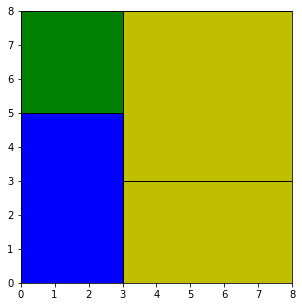

instance:2
2


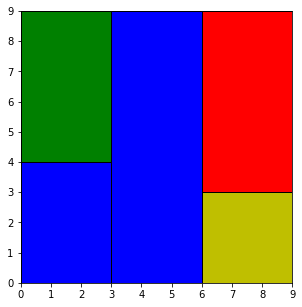

instance:3
3


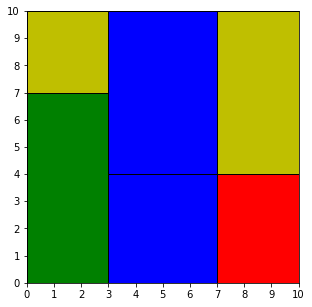

instance:4
4


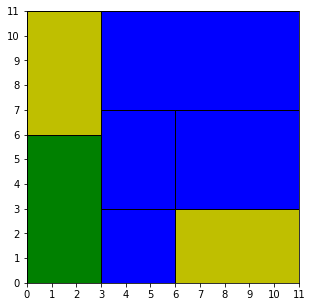

instance:5
5


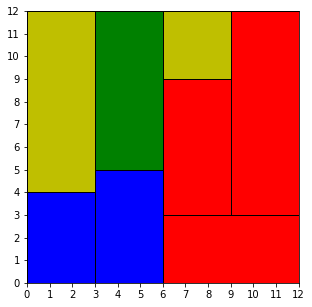

instance:6
6


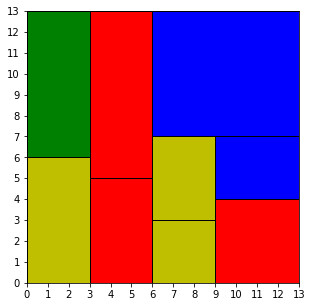

instance:7
7


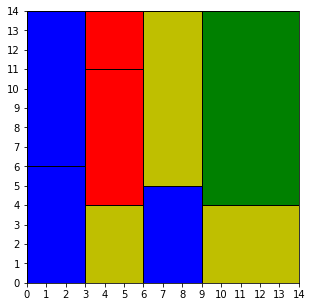

instance:8
8


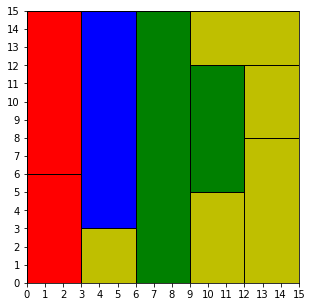

instance:9
9


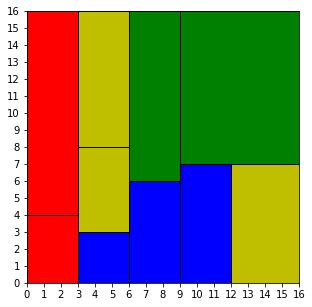

instance:10
10


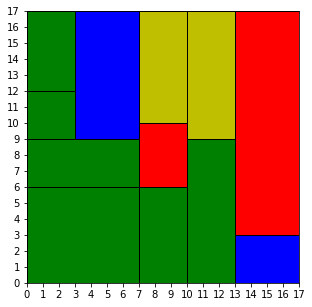

instance:11
11


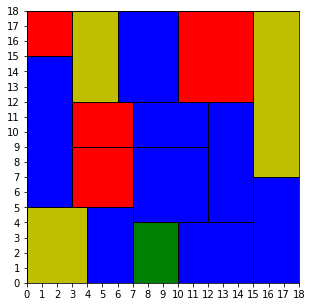

instance:12
12


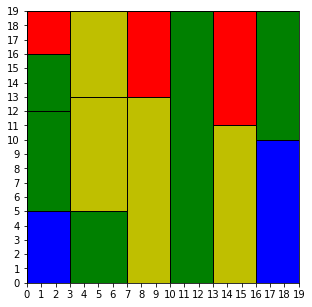

instance:13
13


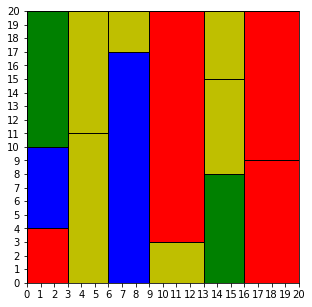

instance:14
14


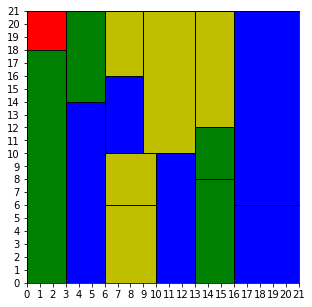

instance:15
15


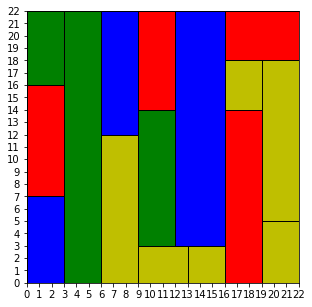

instance:16
16


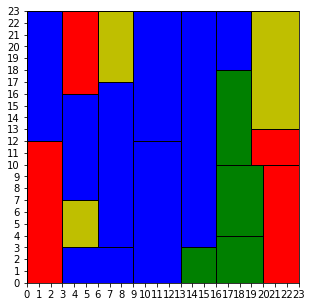

instance:17
17


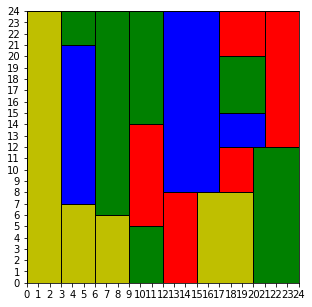

instance:18
18


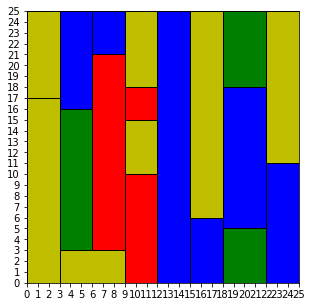

instance:19
19


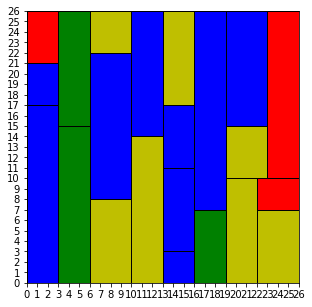

instance:20
20


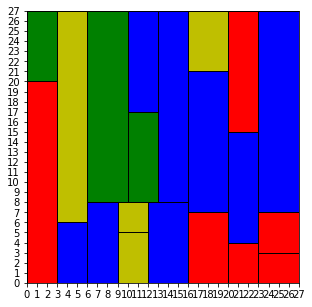

instance:21
21


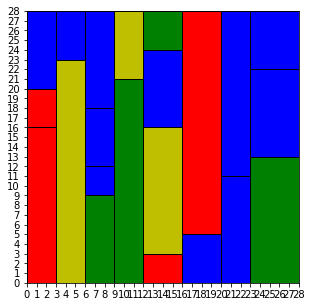

instance:22
22


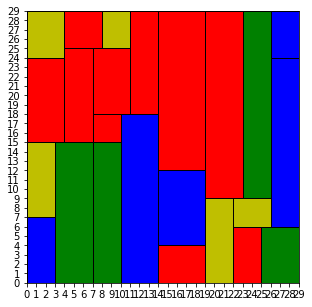

instance:23
23


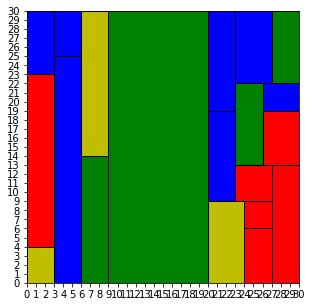

instance:24
24


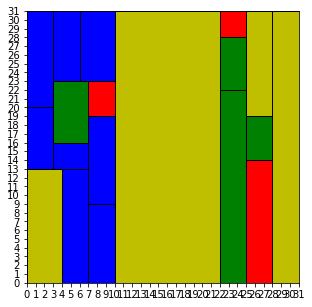

instance:25
25


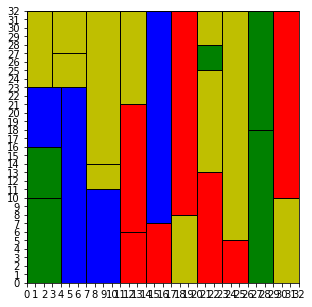

instance:26
26


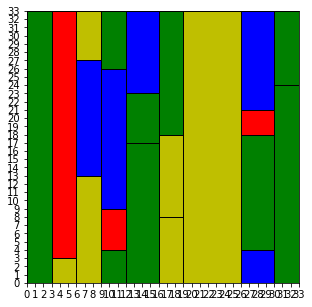

instance:27
27


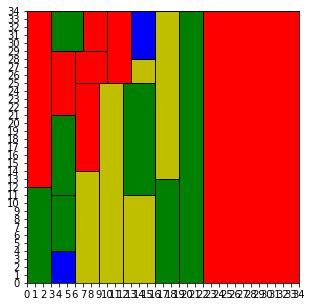

instance:28
28


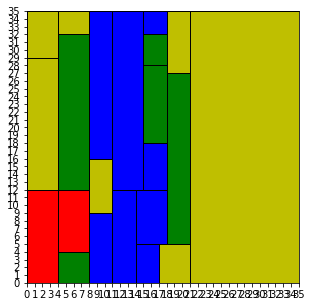

instance:29
29


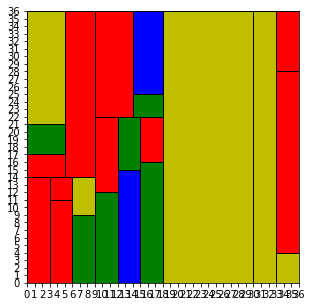

instance:30
30


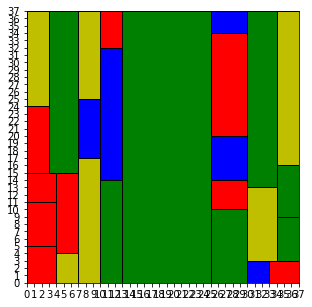

instance:31
31


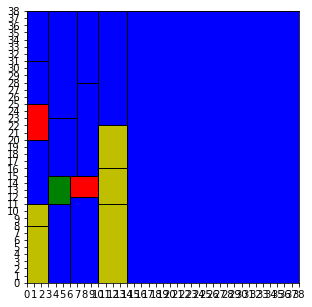

instance:32
out of time
instance:33
33


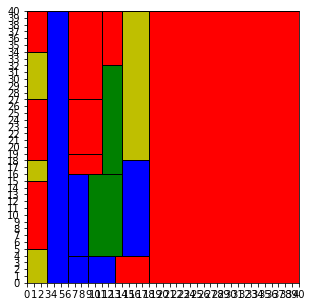

instance:34
34


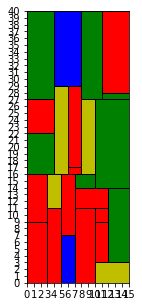

instance:35
35


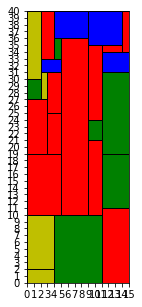

instance:36
36


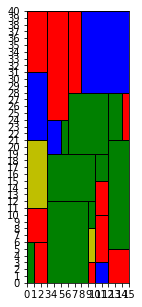

instance:37
37


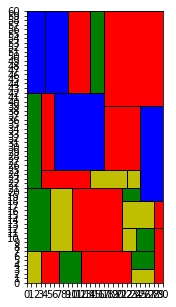

instance:38
out of time
instance:39
39


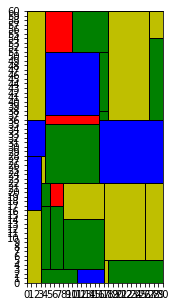

instance:40
out of time


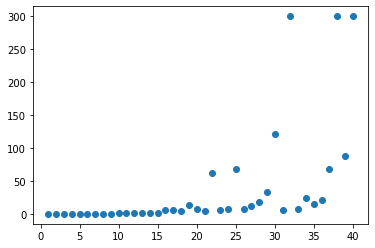

In [13]:
times =[]
instances = range(1,41)
for i in instances:
  filename = f"./instances/ins-{i}.txt"
  print(f"instance:{i}")
  with open(filename, "r") as file1:
    FileasList = file1.readlines()
  W=int(FileasList[0])
  N=int(FileasList[1])
  rects=[]
  results=[]
  totarea=0
  for n in range(2,2+N):
    values = [int(s) for s in FileasList[n].split() if s.isdigit()]
    w =values[0]
    h = values[1]
    totarea += h*w
    rects.append([w,h])
    results.append([w,h])
  solved,(t_tot,t_solve),(m,c,H) = solve(rects,W, opt=True, order=True)
  times.append(t_tot)
  if solved:
    for r in range(len(rects)):
      results[r].append(c[r][0])
      results[r].append(c[r][1])
    fileout = f"outputs/out-{i}.txt"
    with open(fileout, "w") as file2:
      print(i)
      file2.write(f"{W}\n")
      file2.write(f"{N}\n")
      for i in range(len(results)):
        file2.write(f"{results[i]}\n")
    plot_result(results,W,H)
plt.scatter(instances,times)

#Tests

##direct encoding vs order encoding

In [ ]:

summary = [['instance','H_base','time_direct','H_opt','time_order','time_diff']]
for i in range(11,21):
  instance_results = []
  instance_results.append(i)
  filename = f"./instances/ins-{i}.txt"
  print(f"instance:{i}")
  with open(filename, "r") as file1:
    FileasList = file1.readlines()
  W=int(FileasList[0])
  N=int(FileasList[1])
  rects=[]
  totarea=0
  for n in range(2,2+N):
    values = [int(s) for s in FileasList[n].split() if s.isdigit()]
    w =values[0]
    h = values[1]
    totarea += h*w
    rects.append([w,h])
  
  solved,(elapsed_tot, elapsed1),(m,c,H) = solve(rects,W, opt=False, order=False)
  if solved:
    instance_results += [H,elapsed1]
  else:
    instance_results += ["fail","oot"]

  solved,(elapsed_tot, elapsed2),(m,c,H) = solve(rects,W, opt=False, order=True)
  if solved:
    instance_results += [H,elapsed2, elapsed1-elapsed2]
  else:
    instance_results += ["fail","oot"]

  summary.append(instance_results)
print(tabulate(summary))

instance:11
instance:12
instance:13
instance:14
instance:15
instance:16
instance:17
instance:18
instance:19
instance:20
--------  ------  ------------------  -----  -------------------  ------------------
instance  H_base  time_direct         H_opt  time_order           time_diff
11        18      9.636278867721558   18     0.2274916172027588   9.408787250518799
12        19      2.7154836654663086  19     0.07502388954162598  2.6404597759246826
13        20      0.6788356304168701  20     0.05682778358459473  0.6220078468322754
14        21      1.1188957691192627  21     0.05506539344787598  1.0638303756713867
15        22      1.4919278621673584  22     0.06217360496520996  1.4297542572021484
16        23      5.640883445739746   23     1.4453530311584473   4.195530414581299
17        24      9.390121698379517   24     0.10560035705566406  9.284521341323853
18        25      6.075580358505249   25     3.589163303375244    2.486417055130005
19        26      69.62260890007019   26   

## Order encoding, both with and without optimization

In [ ]:

summary = [['instance','H_base','time_base','H_opt','time_opt','time_diff']]
for i in range(11,21):
  instance_results = []
  instance_results.append(i)
  filename = f"./instances/ins-{i}.txt"
  print(f"instance:{i}")
  with open(filename, "r") as file1:
    FileasList = file1.readlines()
  W=int(FileasList[0])
  N=int(FileasList[1])
  rects=[]
  totarea=0
  for n in range(2,2+N):
    values = [int(s) for s in FileasList[n].split() if s.isdigit()]
    w =values[0]
    h = values[1]
    totarea += h*w
    rects.append([w,h])
  
  solved,(elapsed_tot, elapsed1),(m,c,H) = solve(rects,W, opt=False, order=True)
  if solved:
    instance_results += [H,elapsed1]
  else:
    instance_results += ["fail","oot"]

  solved,(elapsed_tot, elapsed2),(m,c,H) = solve(rects,W, opt=True, order=True)
  if solved:
    instance_results += [H,elapsed2, elapsed1-elapsed2]
  else:
    instance_results += ["fail","oot"]

  summary.append(instance_results)
print(tabulate(summary))

instance:11
instance:12
instance:13
instance:14
instance:15
instance:16
instance:17
instance:18
instance:19
instance:20
--------  ------  --------------------  -----  --------------------  ---------------------
instance  H_base  time_base             H_opt  time_opt              time_diff
11        18      0.16404962539672852   18     1.079375982284546     -0.9153263568878174
12        19      0.030086517333984375  19     0.04007768630981445   -0.009991168975830078
13        20      0.2407674789428711    20     0.04522347450256348   0.19554400444030762
14        21      0.0650949478149414    21     0.2431344985961914    -0.17803955078125
15        22      0.04987287521362305   22     0.058794260025024414  -0.008921384811401367
16        23      0.42028212547302246   23     0.2897191047668457    0.13056302070617676
17        24      0.11040878295898438   24     1.589130163192749     -1.4787213802337646
18        25      0.6351842880249023    25     1.166503667831421     -0.5313193798065

##Direct encoding

No optimization was given, since the difference in results is already clear when running the base model

In [ ]:
#test range of instances
summary =[['instance','H','time']]
for i in range(1,11):
  filename = f"./instances/ins-{i}.txt"
  print(f"instance:{i}")
  with open(filename, "r") as file1:
    FileasList = file1.readlines()
  W=int(FileasList[0])
  N=int(FileasList[1])
  rects=[]
  totarea=0
  for n in range(2,2+N):
    values = [int(s) for s in FileasList[n].split() if s.isdigit()]
    w =values[0]
    h = values[1]
    totarea += h*w
    rects.append([w,h])

  solved,(t,elapsed),(m,c,H) = solve(rects,W, opt=True, order=True)
  summary.append([i,H,elapsed])


print(tabulate(summary))

#Toy example for rotations



Rectangles: [3,2] and [1,3], width = 3

In [ ]:
rects = [[3,2],[1,3],[2,3],[3,1]]
W = 3
H = 4
px = [[Bool(f"x{r+1}<{x}") for x in range(W)] for r in range(len(rects))]
py = [[Bool(f"y{r+1}<{y}") for y in range(H)] for r in range(len(rects))]
used = [Bool(f"r_{r+1}_used") for r in range(len(rects))]
under = [[Bool(f"r{ri+1}_under_r{rj+1}") if ri != rj else 0 for rj in range(len(rects)) ] for ri in range(len(rects))]
left = [[Bool(f"r{ri+1}_leftof_r{rj+1}")  if rj!=ri else 0 for rj in range(len(rects))] for ri in range(len(rects))]


In [ ]:
s= Solver()
for r in range(len(rects)):
  for xi in range(W-rects[r][0],W):
    s.add(px[r][xi])
  for yi in range(H-rects[r][1],H):
    s.add(py[r][yi])
for r in range(len(rects)):
  for e in range(W-1):
    s.add(Or(Not(px[r][e]),px[r][e+1]))
  for f in range(H-1):
    s.add(Or(Not(py[r][f]),py[r][f+1]))
for ri in range(len(rects)):
  for rj in range(len(rects)):
    if ri != rj :
      #print((ri,rj))
      s.add(Or(
          Not(left[ri][rj]),
          Not(px[rj][rects[ri][0]-1])
      )) # left(ri,rj) -> xj > wi, lower bound for xj
      for e in range(0,W-rects[ri][0]):
        s.add(Or(
            Not(left[ri][rj]),
            px[ri][e],
            Not(px[rj][e+rects[ri][0]])
        )) #for any e: left(ri,rj) -> (xi <e v ! xj<e+wi)

      s.add(Or(
          Not(under[ri][rj]),
          Not(py[rj][rects[ri][1]-1])
      )) #under(ri,rj)-> yj > hi, lower bound for yj

      for f in range(0,H-rects[ri][1]):
        s.add(Or(
            Not(under[ri][rj]),
            py[ri][f],
            Not(py[rj][f+rects[ri][1]])
      )) #for any f, under(ri,rj) -> (yj <= f+hi ->yi <= f)

for i in range(2):
  s.add(Xor(used[i],used[i+2]))
for (i,j) in itertools.combinations(range(len(rects)),2):
  s.add(Implies(And(used[i],used[j]), Or(left[i][j],left[j][i],under[i][j],under[j][i])))

In [ ]:
s.check()
m = s.model()
for t in m.decls():
  if is_true(m[t]):
    print(t)

r2_leftof_r3
x3<1
x4<0
x1<2
x3<2
r_3_used
x1<1
y2<2
r_2_used
y4<3
x2<1
x2<0
y1<3
x4<1
x1<0
y3<1
y2<3
y3<2
y2<1
x4<2
y3<3
x2<2
y1<2
